In [1]:
import numpy as np
import torch
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
dat_ = np.load('./data/highd_coxph_stratified_model_2d_subjective.npz', allow_pickle=True)

In [3]:
params_ = dat_['params_']
baseline_survival_ = dat_['baseline_survival_']
baseline_hazard_ = dat_['baseline_hazard_']

In [4]:
_, n_covariates = params_.shape

In [6]:
@torch.no_grad()
def simulate_agents(
    N: int,
    T: int,
    dt: float,
    dH0_BA: torch.Tensor,   # (K,)
    dH0_BC: torch.Tensor,   # (K,)
    dH0_CB: torch.Tensor,   # (K,)
    lambda_AB_t,            # (T,) tensor or float
    eta_BA_t: torch.Tensor, # (T,)
    eta_BC_t: torch.Tensor, # (T,)
    eta_CB_t: torch.Tensor, # (T,)
    p0_state: torch.Tensor = None,  # (N,) int {0,1,2}; default all in A
    device: str = "cuda",
    exp_clip: float = 20.0,
    seed: int = None,
):
    """
    Returns:
      states_t: (T+1, N) int64 where states_t[t, n] in {0(A),1(B),2(C)}
    """
    dev = torch.device(device)
    dtype = torch.float32
    K = int(dH0_BA.shape[0])

    # Move tensors to device/dtype
    dH0_BA = dH0_BA.to(dev, dtype)
    dH0_BC = dH0_BC.to(dev, dtype)
    dH0_CB = dH0_CB.to(dev, dtype)

    if not torch.is_tensor(lambda_AB_t) or lambda_AB_t.ndim == 0:
        lambda_AB_t = torch.full((T,), float(lambda_AB_t), device=dev, dtype=dtype)
    else:
        lambda_AB_t = lambda_AB_t.to(dev, dtype)

    eta_BA_t = eta_BA_t.to(dev, dtype)
    eta_BC_t = eta_BC_t.to(dev, dtype)
    eta_CB_t = eta_CB_t.to(dev, dtype)

    if seed is not None:
        torch.manual_seed(seed)

    # Initial states and ages
    if p0_state is None:
        states = torch.zeros(N, device=dev, dtype=torch.long)  # all A
    else:
        states = p0_state.to(dev, dtype=torch.long)
    ages = torch.zeros(N, device=dev, dtype=torch.long)        # age bin index 0..K-1

    # Record matrix
    states_t = torch.empty(T+1, N, device=dev, dtype=torch.long)
    states_t[0] = states

    dt_t = torch.tensor(dt, device=dev, dtype=dtype)

    A, B, C = 0, 1, 2
    eps = 1e-12

    for t in trange(T):
        # Build masks per state
        inA = (states == A)
        inB = (states == B)
        inC = (states == C)

        # --- A -> B (calendar-time Poisson, same for all age bins) ---
        if inA.any():
            Lam_AB = torch.clamp(lambda_AB_t[t] * dt_t, min=0.0)
            p_AB = 1.0 - torch.exp(-Lam_AB)     # scalar
            jump_AB = torch.rand(inA.sum(), device=dev) < p_AB
        else:
            jump_AB = torch.empty(0, device=dev, dtype=torch.bool)

        # --- B -> {A,C} competing, depends on age bin ---
        if inB.any():
            age_idx_B = ages[inB].clamp_max(K-1)
            eBA = torch.exp(torch.clamp(eta_BA_t[t], min=-exp_clip, max=exp_clip))
            eBC = torch.exp(torch.clamp(eta_BC_t[t], min=-exp_clip, max=exp_clip))
            Lam_BA = (dH0_BA[age_idx_B] * eBA).clamp_min(0.0)
            Lam_BC = (dH0_BC[age_idx_B] * eBC).clamp_min(0.0)
            Lout_B = Lam_BA + Lam_BC
            p_jump_B = 1.0 - torch.exp(-Lout_B)
            # sample jump/no-jump
            uB = torch.rand(inB.sum(), device=dev)
            will_jump_B = uB < p_jump_B
            # among jumpers, sample destination with prob Lam_BA / (Lam_BA + Lam_BC)
            wBA = torch.where(Lout_B > 0, Lam_BA / (Lout_B + eps), torch.zeros_like(Lout_B))
            uDest = torch.rand(inB.sum(), device=dev)
            goA = (uDest < wBA) & will_jump_B
            goC = will_jump_B & (~goA)
        else:
            will_jump_B = goA = goC = torch.empty(0, device=dev, dtype=torch.bool)

        # --- C -> B single exit, depends on age bin ---
        if inC.any():
            age_idx_C = ages[inC].clamp_max(K-1)
            eCB = torch.exp(torch.clamp(eta_CB_t[t], min=-exp_clip, max=exp_clip))
            Lam_CB = (dH0_CB[age_idx_C] * eCB).clamp_min(0.0)
            p_jump_C = 1.0 - torch.exp(-Lam_CB)
            jump_CB = torch.rand(inC.sum(), device=dev) < p_jump_C
        else:
            jump_CB = torch.empty(0, device=dev, dtype=torch.bool)

        # --- Apply transitions (reset age to 0 on jump) ---
        # A->B
        if inA.any():
            idxA = inA.nonzero(as_tuple=False).squeeze(1)
            idxA_jump = idxA[jump_AB]
            states[idxA_jump] = B
            ages[idxA_jump] = 0

        # B->A and B->C
        if inB.any():
            idxB = inB.nonzero(as_tuple=False).squeeze(1)
            idxB_goA = idxB[goA]
            idxB_goC = idxB[goC]
            states[idxB_goA] = A
            states[idxB_goC] = C
            ages[idxB_goA] = 0
            ages[idxB_goC] = 0

        # C->B
        if inC.any():
            idxC = inC.nonzero(as_tuple=False).squeeze(1)
            idxC_jump = idxC[jump_CB]
            states[idxC_jump] = B
            ages[idxC_jump] = 0

        # --- Age increment for everyone who did NOT jump ---
        # Rebuild masks after transitions
        jumped = torch.zeros(N, device=dev, dtype=torch.bool)
        if inA.any():
            jumped[idxA_jump] = True
        if inB.any():
            jumped[idxB_goA] = True
            jumped[idxB_goC] = True
        if inC.any():
            jumped[idxC_jump] = True

        stayers = ~jumped
        ages[stayers] = torch.clamp(ages[stayers] + 1, max=K-1)

        # Record states
        states_t[t+1] = states

    return states_t


In [66]:
N = 50000
Seconds = 600
T = int(5*Seconds)
dt = 1

p0_state = torch.full((N,), 0, dtype=torch.long, device="cuda")  # 1 = B

covariate_over_time = np.zeros((T, n_covariates))
covariate_over_time[:,2] = 1
# covariate_over_time[:,5] = 1

X_t = torch.as_tensor(covariate_over_time, device='cuda', dtype=torch.float32)  # (T, F)
beta_BA = torch.as_tensor(params_[1], device='cuda', dtype=torch.float32)          # (F,)
beta_BC = torch.as_tensor(params_[0], device='cuda', dtype=torch.float32)          # (F,)
beta_CB = torch.as_tensor(params_[3], device='cuda', dtype=torch.float32)          # (F,)
eta_BA_t = X_t @ beta_BA   # 
eta_BC_t = X_t @ beta_BC   # 
eta_CB_t = X_t @ beta_CB   # 

lambda_AB_series = np.full(T, 0.2/10 )
lambda_AB_t = torch.as_tensor(lambda_AB_series)  # (T,) or float

dh0_BC = torch.tensor(np.append([0], baseline_hazard_[:,0]))
dh0_BA = torch.tensor(np.append([0], baseline_hazard_[:,2]))
dh0_CB = torch.tensor(np.append([0], baseline_hazard_[:,6]))

In [67]:
states_t = simulate_agents(
    N=N, T=T, dt=dt,
    dH0_BA=dh0_BA, dH0_BC=dh0_BC, dH0_CB=dh0_CB,
    lambda_AB_t=lambda_AB_t,
    eta_BA_t=eta_BA_t, eta_BC_t=eta_BC_t, eta_CB_t=eta_CB_t,
    p0_state=p0_state,
    device="cuda",
    seed=int(torch.seed())
)

100%|██████████| 3000/3000 [00:10<00:00, 294.63it/s]


In [68]:
torch.sum(states_t==0, dim=1)

tensor([50000, 49023, 48109,  ..., 41211, 41146, 41105], device='cuda:0')

(0.0, 60.0)

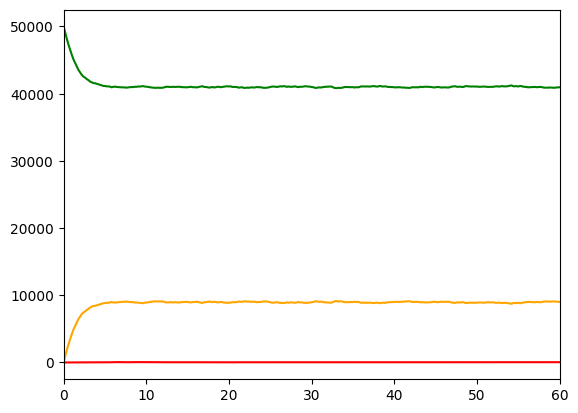

In [70]:
plt.plot(np.arange(0, T+1)*0.2, torch.sum(states_t==0, dim=1).cpu().numpy(), label='safe', color='green')
plt.plot(np.arange(0, T+1)*0.2, torch.sum(states_t==1, dim=1).cpu().numpy(), label='disturbance', color='orange')
plt.plot(np.arange(0, T+1)*0.2, torch.sum(states_t==2, dim=1).cpu().numpy(), label='conflict', color='red')
plt.xlim(0, 60)

In [9]:
(states_t==2).sum()

tensor(39097, device='cuda:0')

In [83]:
# Monte-Carlo roll out baseline conditions
N_rolls = 100
conflict_steps_per_rollout = []
for _ in trange(N_rolls):
    states_t = simulate_agents(
        N=N, T=T, dt=dt,
        dH0_BA=dh0_BA, dH0_BC=dh0_BC, dH0_CB=dh0_CB,
        lambda_AB_t=lambda_AB_t,
        eta_BA_t=eta_BA_t, eta_BC_t=eta_BC_t, eta_CB_t=eta_CB_t,
        p0_state=p0_state,
        device="cuda",
        seed=int(torch.seed())
    )
    conflict_steps = (states_t==2).sum()
    conflict_steps_per_rollout.append(conflict_steps.cpu().item())



100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


(array([ 2.,  0.,  0.,  2.,  2.,  3.,  6., 11., 10.,  4., 10.,  8.,  7.,
         7., 11.,  2.,  7.,  4.,  3.,  1.]),
 array([208086.  , 209065.55, 210045.1 , 211024.65, 212004.2 , 212983.75,
        213963.3 , 214942.85, 215922.4 , 216901.95, 217881.5 , 218861.05,
        219840.6 , 220820.15, 221799.7 , 222779.25, 223758.8 , 224738.35,
        225717.9 , 226697.45, 227677.  ]),
 <BarContainer object of 20 artists>)

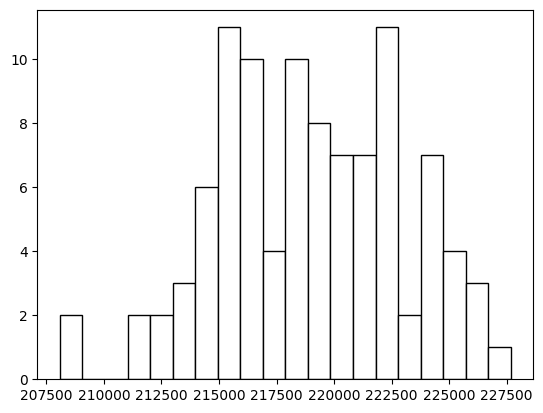

In [84]:
plt.hist(conflict_steps_per_rollout, bins=20, ec='black', fc='white')

In [11]:
import torch

class SemiMarkovGPU:
    """
    States: 0=A, 1=B, 2=C
    Age grid: K bins; dt should equal the bin width used for Cox baselines.
    """

    def __init__(self,
                 dH0_BA: torch.Tensor,  # (K,)
                 dH0_BC: torch.Tensor,  # (K,)
                 dH0_CB: torch.Tensor,  # (K,)
                 dt: float,
                 device: str = "cuda",
                 dtype: torch.dtype = torch.float32,
                 exp_clip: float = 20.0):
        self.device = torch.device(device)
        self.dtype = dtype
        self.dt = torch.tensor(dt, device=self.device, dtype=self.dtype)
        # store age-baseline increments on device
        self.dH0_BA = dH0_BA.to(self.device, dtype=self.dtype)  # (K,)
        self.dH0_BC = dH0_BC.to(self.device, dtype=self.dtype)  # (K,)
        self.dH0_CB = dH0_CB.to(self.device, dtype=self.dtype)  # (K,)
        self.K = self.dH0_BA.shape[0]
        self.exp_clip = exp_clip

    @staticmethod
    def _safe_exp(x, clip):
        return torch.exp(torch.clamp(x, min=-clip, max=clip))

    def roll(self,
             T: int,
             p0_state: torch.Tensor,       # (3,) probs over A,B,C at t0
             eta_BA_t: torch.Tensor,       # (T,) log multipliers for B->A
             eta_BC_t: torch.Tensor,       # (T,) log multipliers for B->C
             eta_CB_t: torch.Tensor,       # (T,) log multipliers for C->B
             lambda_AB_t,                  # (T,) or scalar rate for A->B (calendar time)
             return_marginals: bool = True,
             compile_with_torch: bool = False):
        """
        Returns:
          p_marg: (T+1, 3) time series of state probabilities (if return_marginals)
          or      (T+1, 3, K) full age-state distribution.
        """

        # move inputs to device/dtype
        p0_state = p0_state.to(self.device, dtype=self.dtype)
        eta_BA_t = eta_BA_t.to(self.device, dtype=self.dtype)
        eta_BC_t = eta_BC_t.to(self.device, dtype=self.dtype)
        eta_CB_t = eta_CB_t.to(self.device, dtype=self.dtype)

        if torch.is_tensor(lambda_AB_t):
            lambda_AB_t = lambda_AB_t.to(self.device, dtype=self.dtype)
        else:
            lambda_AB_t = torch.tensor(lambda_AB_t, device=self.device, dtype=self.dtype).expand(T)

        # initialize age-state distribution: all mass in age bin 0 of each starting state
        p_age = torch.zeros((3, self.K), device=self.device, dtype=self.dtype)
        p_age[:, 0] = p0_state

        # storage
        if return_marginals:
            out = torch.zeros((T+1, 3), device=self.device, dtype=self.dtype)
            out[0] = p_age.sum(dim=1)
        else:
            out = torch.zeros((T+1, 3, self.K), device=self.device, dtype=self.dtype)
            out[0] = p_age

        # optional compile for PyTorch 2.x
        step_fn = self._step_once
        if compile_with_torch:
            try:
                step_fn = torch.compile(step_fn)  # type: ignore
            except Exception:
                pass  # fall back silently

        # main loop over time steps (vectorized over age bins and transitions)
        for t in trange(T):
            p_age = step_fn(p_age,
                            self.dH0_BA, self.dH0_BC, self.dH0_CB,
                            eta_BA_t[t], eta_BC_t[t], eta_CB_t[t],
                            lambda_AB_t[t], self.dt,
                            self.exp_clip)
            # normalize drift (rare, but safe)
            s = p_age.sum()
            if s > 0:
                p_age = p_age / s

            if return_marginals:
                out[t+1] = p_age.sum(dim=1)
            else:
                out[t+1] = p_age

        return out

    @staticmethod
    def _step_once(p_age,
                   dH0_BA, dH0_BC, dH0_CB,
                   eta_BA, eta_BC, eta_CB,
                   lam_AB, dt,
                   exp_clip):
        """
        One DT step using Poisson thinning; fully vectorized over K age bins.
        p_age: (3,K)
        Returns p_age_next: (3,K)
        """
        K = dH0_BA.shape[0]
        A, B, C = 0, 1, 2

        # --- A: A->B is Poisson in calendar time ---
        # per-step integrated hazard Λ_AB = λ_AB * dt (scalar)
        Lam_AB = torch.clamp(lam_AB * dt, min=0.0)
        p_jump_AB = 1.0 - torch.exp(-Lam_AB)
        p_stay_A = 1.0 - p_jump_AB

        # Ageing shift for A
        pA = p_age[A]  # (K,)
        pA_stay = pA * p_stay_A
        pA_next = torch.zeros_like(pA)
        # shift right by 1 bin; cap at last bin
        pA_next[1:] = pA_stay[:-1]
        pA_next[-1] += pA_stay[-1]
        # jumps to B age 0
        jump_AB_mass = (pA * p_jump_AB).sum()

        # --- B: semi-Markov with competing exits B->A, B->C ---
        # per-bin integrated hazards Λ_{BA,k} = dH0_BA[k] * exp(eta_BA)
        eBA = torch.exp(torch.clamp(eta_BA, min=-exp_clip, max=exp_clip))
        eBC = torch.exp(torch.clamp(eta_BC, min=-exp_clip, max=exp_clip))
        Lam_BA = torch.clamp(dH0_BA * eBA, min=0.0)  # (K,)
        Lam_BC = torch.clamp(dH0_BC * eBC, min=0.0)  # (K,)
        Lout_B = Lam_BA + Lam_BC
        p_jump_B = 1.0 - torch.exp(-Lout_B)
        p_stay_B = 1.0 - p_jump_B
        # weights (handle zeros safely)
        wBA = torch.where(Lout_B > 0, Lam_BA / Lout_B, torch.zeros_like(Lout_B))
        wBC = torch.where(Lout_B > 0, Lam_BC / Lout_B, torch.zeros_like(Lout_B))

        pB = p_age[B]  # (K,)
        # stay & age
        pB_stay = pB * p_stay_B
        pB_next = torch.zeros_like(pB)
        pB_next[1:] = pB_stay[:-1]
        pB_next[-1] += pB_stay[-1]
        # jumps from B
        jump_B_total = pB * p_jump_B             # (K,)
        jump_BA_mass = (jump_B_total * wBA).sum()
        jump_BC_mass = (jump_B_total * wBC).sum()

        # --- C: semi-Markov single exit C->B ---
        eCB = torch.exp(torch.clamp(eta_CB, min=-exp_clip, max=exp_clip))
        Lam_CB = torch.clamp(dH0_CB * eCB, min=0.0)  # (K,)
        p_jump_C = 1.0 - torch.exp(-Lam_CB)
        p_stay_C = 1.0 - p_jump_C

        pC = p_age[C]
        pC_stay = pC * p_stay_C
        pC_next = torch.zeros_like(pC)
        pC_next[1:] = pC_stay[:-1]
        pC_next[-1] += pC_stay[-1]
        jump_CB_mass = (pC * p_jump_C).sum()

        # --- Collect next distribution ---
        p_next = torch.stack([pA_next, pB_next, pC_next], dim=0)
        # landings at age 0
        p_next[B, 0] += jump_AB_mass + jump_CB_mass
        p_next[A, 0] += jump_BA_mass
        p_next[C, 0] += jump_BC_mass

        return p_next


In [70]:
Seconds = 3600*5
T = int(5*Seconds)
dt = 1

p0_state = torch.full((N,), 0, dtype=torch.long, device="cuda")  # 1 = B

covariate_over_time = np.zeros((T, n_covariates))
# covariate_over_time[:,2] = 1
# covariate_over_time[:,5] = 1

X_t = torch.as_tensor(covariate_over_time, device='cuda', dtype=torch.float32)  # (T, F)
beta_BA = torch.as_tensor(params_[1], device='cuda', dtype=torch.float32)          # (F,)
beta_BC = torch.as_tensor(params_[0], device='cuda', dtype=torch.float32)          # (F,)
beta_CB = torch.as_tensor(params_[3], device='cuda', dtype=torch.float32)          # (F,)
eta_BA_t = X_t @ beta_BA   # 
eta_BC_t = X_t @ beta_BC   # 
eta_CB_t = X_t @ beta_CB   # 

disturbance_interval_second = 180
lambda_AB_series = np.full(T, 1/disturbance_interval_second*0.2)
lambda_AB_t = torch.as_tensor(lambda_AB_series)  # (T,) or float

dh0_BC = torch.tensor(np.append([0], baseline_hazard_[:,0]))
dh0_BA = torch.tensor(np.append([0], baseline_hazard_[:,2]))
dh0_CB = torch.tensor(np.append([0], baseline_hazard_[:,6]))

In [71]:
engine = SemiMarkovGPU(dh0_BC, dh0_BA, dh0_CB, dt=1, device="cuda")

In [72]:
p0_state_ = torch.tensor([0.1604, 0.4514, 0.3882])   

In [73]:
p_of_t = engine.roll(
    T=T,
    p0_state=p0_state_,
    eta_BA_t=eta_BA_t,
    eta_BC_t=eta_BC_t,
    eta_CB_t=eta_CB_t,
    lambda_AB_t=lambda_AB_t,
    return_marginals=True,          # → (T+1, 3)
    compile_with_torch=True         # optional PyTorch 2.x compile
)

100%|██████████| 90000/90000 [01:26<00:00, 1038.77it/s]


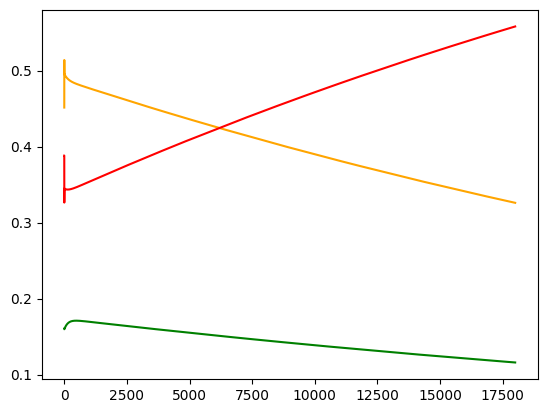

In [74]:
plt.plot(np.arange(T+1)*0.2, p_of_t[:,0].cpu().numpy(), color='green', label='safe')
plt.plot(np.arange(T+1)*0.2, p_of_t[:,1].cpu().numpy(), color='orange', label='disturbance')
plt.plot(np.arange(T+1)*0.2, p_of_t[:,2].cpu().numpy(), color='red', label='conflict')

In [69]:
p_of_t[-1]

tensor([0.1604, 0.4514, 0.3882], device='cuda:0')